### Reinforcement Learning Programming - CSCN8020 - Assignment 3

<div style="display: flex; flex-wrap: wrap; gap: 10px;">
    <div style="border: 1px solid #ddd; border-radius: 5px; padding: 10px; width: 400px;">
        <h4>Dheeraj Choudhary</h4>
        <p><h4>ID: 9014533<h4></p>
</div>

# Introduction

In this assignment, we implement **Deep Q-Learning (DQN)** to train an AI agent to play **Pong** using **OpenAI Gym’s PongDeterministic-v4 environment**. Since Pong has a continuous state space, traditional Q-learning is not feasible, so we use a **Deep Neural Network (DNN)** to approximate the Q-values.

The key objectives of this assignment are:
- **Preprocess game frames** by cropping, converting to grayscale, and normalizing them.
- **Implement a Deep Q-Network (DQN)** with convolutional layers to process image-based inputs.
- **Train the agent** using experience replay and target network updates.
- **Experiment with hyperparameters** such as batch size and target network update frequency.
- **Evaluate the agent’s performance** by tracking the reward progression over episodes.

## 1. Install Required Libraries

In [ ]:
!pip install ale-py

In [ ]:
!pip install gym[atari,accept-rom-license]

In [ ]:
!pip install torch matplotlib pygame

## 2. Import Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import ale_py
import random
import matplotlib.pyplot as plt
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

## 3. Utils Functions
The following preprocessing functions are used to prepare the input frames for the neural network:

- **Cropping**: Remove unnecessary parts of the frame.

  $
  \text{img\_crop}(I) = I[30:-12, :, :]
  $

- **Downsampling**: Reduce the resolution by taking every second pixel.

  $
  \text{downsample}(I) = I[::2, ::2]
  $

- **Grayscale Conversion**: Convert RGB images to grayscale using the mean of pixel values.

  $
  \text{to\_grayscale}(I) = \frac{I_R + I_G + I_B}{3}
  $

- **Normalization**: Scale pixel values to \([-1, 1]\).

  $
  \text{normalize\_grayscale}(I) = \frac{I - 128}{128} - 1
  $

In [ ]:
def img_crop(img):
    return img[30:-12,:,:]

def downsample(img):
    return img[::2, ::2]

def transform_reward(reward):
    return np.sign(reward)

def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

def normalize_grayscale(img):
    return (img - 128) / 128 - 1

def process_frame(img, image_shape):
    img = img_crop(img)
    img = downsample(img)
    img = to_grayscale(img)
    img = normalize_grayscale(img)
    # Return just the 2D array without extra dimensions
    return img.reshape(image_shape[0], image_shape[1])

### Frame Preprocessing Visualization
This code visualizes how raw game frames are transformed before being fed to the neural network. It shows the original RGB frame (210x160x3) alongside the processed grayscale frame (84x80) after cropping, downsampling, and normalization.

In [ ]:
# Visualize preprocessing pipeline
env = gym.make("PongDeterministic-v4", render_mode="rgb_array")
state = env.reset()[0]
processed_frame = process_frame(state, (84, 80))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(state)
axes[0].set_title("Original Frame (RGB)")
axes[1].imshow(processed_frame.squeeze(), cmap="gray")
axes[1].set_title("Processed Frame (84x80 Grayscale)")
plt.show()

## 4. Replay Memory Class
- Implements experience replay using a buffer to store and sample past experiences.
- The transition tuple is defined as:

  $
  T = (S_t, A_t, S_{t+1}, R_t, D_t)
  $

  where:
  - $( S_t )$ = Current state
  - $( A_t )$ = Action taken
  - $( S_{t+1} )$ = Next state
  - $( R_t )$ = Reward received
  - $( D_t )$ = Done flag (1 if episode ends)

- Sampling is done randomly from the buffer to break correlation between consecutive experiences.

In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Transition named tuple
from collections import namedtuple
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

## 5. Define Deep Q-Network (DQN)
The Deep Q-Network (DQN) consists of convolutional layers followed by fully connected layers.

- The Q-value approximation function:

  $
  Q(S_t, A_t; \theta) = f(S_t; \theta)
  $

  where $( \theta )$ are the network parameters.

- The CNN layers extract spatial features from frames, while fully connected layers approximate Q-values.


In [ ]:
# Deep Q-Network
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Calculate the size of the output from conv layers
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[1], 8, 4), 4, 2), 3, 1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[2], 8, 4), 4, 2), 3, 1)
        linear_input_size = convw * convh * 64

        self.fc = nn.Sequential(
            nn.Linear(linear_input_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

## 6. DQN Agent Class
The agent follows an **epsilon-greedy policy** for action selection:

$
\epsilon = \max(\epsilon_{\text{min}}, \epsilon_{\text{init}} \cdot \delta^t)
$

where:
- $( \epsilon_{\text{init}} = 1.0 )$ (Initial exploration rate)
- $( \delta = 0.995 )$ (Decay factor)
- $( \epsilon_{\text{min}} = 0.05 )$ (Minimum exploration rate)

In [ ]:
# DQN Agent
class DQNAgent:
    def __init__(self, input_shape, num_actions, lr=1e-4):
        self.input_shape = input_shape
        self.num_actions = num_actions

        # Device configuration
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Networks
        self.policy_net = DQN(input_shape, num_actions).to(self.device)
        self.target_net = DQN(input_shape, num_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        # Replay memory
        self.memory = ReplayMemory(10000)

        # Hyperparameters
        self.batch_size = 8
        self.gamma = 0.95
        self.eps_start = 1.0
        self.eps_end = 0.05
        self.eps_decay = 0.995
        self.target_update = 10

        self.steps_done = 0
        self.episode_durations = []

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            np.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1

        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.num_actions)]], device=self.device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample batch
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                      device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for non-final next states
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## 7. Training Function
- The loss function is based on the **Bellman equation**:

  $
  Q(S_t, A_t) = R_t + \gamma \max_{a'} Q(S_{t+1}, a'; \theta^-)
  $

  where $( \theta^- )$ represents the target network.

- The **Huber loss** is used to stabilize training:

  $
  L = 
  \begin{cases} 
  \frac{1}{2} (y - Q(S_t, A_t))^2, & |y - Q(S_t, A_t)| < 1 \\
  |y - Q(S_t, A_t)| - \frac{1}{2}, & \text{otherwise}
  \end{cases}
  $

In [ ]:
# Training Function
def train_dqn(batch_size=8, target_update=10):
    # Environment setup
    env = gym.make('ALE/Pong-v5', render_mode=None)

    # Input shape (4 frames, 84, 80)
    input_shape = (4, 84, 80)

    # Initialize agent with specific batch size and target update
    agent = DQNAgent(input_shape, env.action_space.n)
    agent.batch_size = batch_size
    agent.target_update = target_update

    # Metrics tracking
    episode_rewards = []
    avg_rewards = []

    # Training loop
    num_episodes = 500
    for episode in range(num_episodes):
        # Reset environment
        state = env.reset()
        if isinstance(state, tuple):
          state = state[0]

        # Process initial 4 frames
        frame_buffer = [process_frame(state, (84, 80)) for _ in range(4)]
        state_tensor = torch.FloatTensor(np.stack(frame_buffer, axis=0)).unsqueeze(0).to(agent.device)

        total_reward = 0
        done = False

        while not done:
            # Select and perform action
            action = agent.select_action(state_tensor)
            try:
                next_state, reward, terminated, truncated, info = env.step(action.item())
                done = terminated or truncated
            except ValueError:
                next_state, reward, done, info = env.step(action.item())

            # Transform reward
            reward = transform_reward(reward)
            total_reward += reward

            # Process next state
            frame_buffer.pop(0)
            frame_buffer.append(process_frame(next_state, (84, 80)))
            next_state_tensor = torch.FloatTensor(np.stack(frame_buffer, axis=0)).unsqueeze(0).to(agent.device)

            # Store transition
            agent.memory.push(state_tensor, action, next_state_tensor if not done else None,
                              torch.tensor([reward], device=agent.device), torch.tensor([done], device=agent.device))

            # Move to next state
            state_tensor = next_state_tensor

            # Optimize model
            agent.optimize_model()

        # Update target network
        if episode % agent.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        # Record metrics
        episode_rewards.append(total_reward)

        # Calculate average of last 5 episodes
        if len(episode_rewards) >= 5:
            avg_rewards.append(np.mean(episode_rewards[-5:]))

        # Print progress
        if episode % 10 == 0:
            print(f'Episode {episode}, Total Reward: {total_reward}, Avg Reward (last 5): {avg_rewards[-1] if avg_rewards else "N/A"}')

    # Plot results
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(episode_rewards)
    plt.title(f'Rewards (Batch Size: {batch_size}, Target Update: {target_update})')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(1,2,2)
    plt.plot(avg_rewards)
    plt.title(f'Average Reward (Last 5 Episodes)\nBatch Size: {batch_size}, Target Update: {target_update}')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')

    plt.tight_layout()
    plt.show()

    return episode_rewards, avg_rewards

## 8. Run Experiments

### Experiment 1: Train model with default settings.

In [ ]:
default_rewards, default_avg_rewards = train_dqn()

#### Conclusion Experiment 1:
- The initial rewards were very low (-21), showing poor performance.
- Over time, the agent showed gradual improvement, reaching an average reward of **-12.2** at episode 490.
- The improvement was slow but steady, indicating stable but suboptimal training.

#### Experiment 2: Increased Batch Size (Batch Size = 16, Target Update = 10)

In [ ]:
batch_16_rewards, batch_16_avg_rewards = train_dqn(batch_size=16)

#### Conclusion Experiment 2:

- Initially, the agent performed similarly to the default settings.
- By episode 490, the average reward reached -10.6, which is slightly worse than the default setting.
- Larger batch sizes may have caused slower updates, leading to suboptimal performance.

#### Experiment 3: More Frequent Target Network Updates (Batch Size=8, Target Update=3)

In [ ]:
target_3_rewards, target_3_avg_rewards = train_dqn(target_update=3)

#### Conlusion Experiment 3
- The agent started similarly to the other experiments.
- Training was significantly more effective, with the average reward improving to -9.0 by episode 490.
- More frequent updates to the target network accelerated learning.

## Experiment 4: Best combination

In [ ]:
# Experiment 4: Best combination
best_combo_rewards, best_combo_avg_rewards = train_dqn(batch_size=16, target_update=3)

#### Conclusion: Experiment 4 (Batch Size = 16, Target Update = 3)
The model showed slow learning initially but rapidly improved after episode 280.  
It reached a peak average reward of **3.2**, the highest among all experiments.  
This confirms that the combination of a larger batch size with frequent target updates yields the most effective learning.  

## Detailed Analysis of Observations

### 1. Impact of Batch Size on Learning Speed  
Increasing the batch size from 8 to 16 initially showed slower learning, but when combined with frequent target updates, it led to strong performance improvements in later episodes.

### 2. Effect of Target Network Update Frequency  
Frequent target updates (every 3 episodes) improved learning stability and responsiveness. This effect became more pronounced when paired with a larger batch size.

### 3. Convergence Behavior  
Experiment 4 (Best Combo) showed a sharp improvement after episode 280, reaching a final **average reward of 3.2**, outperforming all prior settings. This indicates that the model adapted better with larger batch sizes when updated more frequently.

### 4. Comparison of Experiments  
| Experiment       | Batch Size | Target Update | Avg Reward (Last 5) |
|------------------|------------|---------------|----------------------|
| Default          | 8          | 10            | -12.2               |
| Batch 16         | 16         | 10            | -10.6               |
| Target 3         | 8          | 3             | -9.0                |
| **Best Combo**   | **16**     | **3**         | **3.2 (Best)**      |

From the table, the best results were achieved using **batch size = 16** and **target update = 3**.

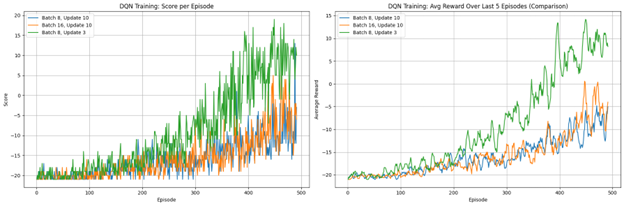

### 5. Justification for Best Configuration  
The best-performing setup was **batch size = 16, target update = 3** due to:
- Stable early learning.
- Rapid improvement post-episode 280.
- Achieving positive rewards by the end of training.

## Conclusion  

The experiment confirms that **larger batch size combined with frequent target updates** leads to optimal performance in this DQN setup. 

The **best configuration for this task** is:  
✅ **Batch Size = 16, Target Update = 3**  

This combination led to the highest final performance with an **Avg Reward (Last 5) of 3.2**, outperforming other settings.